In [6]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

<function matplotlib.pyplot.colorbar(mappable=None, cax=None, ax=None, **kw)>

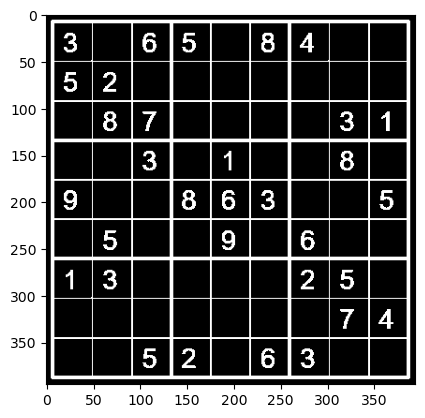

In [7]:
img = cv2.imread('img.png')
plt.imshow(img)
plt.colorbar

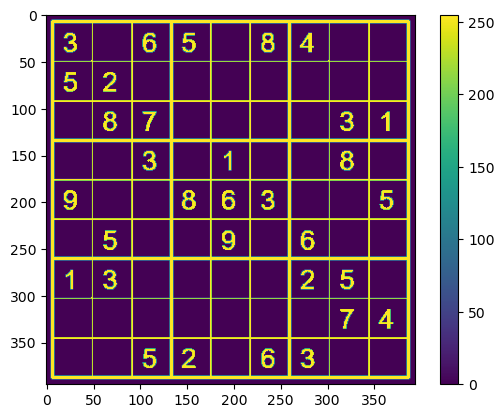

In [8]:
img = cv2.imread('Grids/board2.png')
img = np.invert(img)
imgGrey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thrash = cv2.threshold(imgGrey, 20, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thrash, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
plt.imshow(thrash)
plt.colorbar()

In [9]:
squares = []
for i in range(len(contours)):
    contour = contours[i]
    approx = cv2.approxPolyDP(contour, 0.015*cv2.arcLength(contour, True), True)
    if len(approx) == 4:
        squares.append(i)

In [10]:
def get_square(i):
    contour = contours[squares[len(squares) - i]]

    yMax, yMin = contour[:,0,0].max(), contour[:,0,0].min()
    xMax, xMin = contour[:,0,1].max(), contour[:,0,1].min()

    topLeft = (xMin, yMin)
    
    return img[xMin:xMax, yMin:yMax]


In [11]:
CROPPED_SIZE = 80
SIZE = 100

def get_corners(img):
    top, bottom, left, right = SIZE, 0, SIZE, 0

    for r in range(CROPPED_SIZE):
        for c in range(CROPPED_SIZE):
            if img[r, c] > 100:
                top = min(top, r)
                bottom = max(bottom, r)
                left = min(left, c)
                right = max(right, c)

    width, height = bottom - top, right - left

    return (top, bottom, left, right)


def get_digit(digit_img):
    corners = get_corners(digit_img)
    top, bottom, left, right = corners[0], corners[1], corners[2], corners[3]
    width, height = right - left, bottom - top

    digit_img = digit_img[top:bottom, left:right]

    return digit_img, (width, height)


def get_centered_digit(img):
    img = img[10:90, 10:90]
    img = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)[1]

    cropped_digit_img = get_digit(img)[0]
    width, height = get_digit(img)[1]

    left = (SIZE // 2) - (width // 2)
    right = (SIZE // 2) + (width // 2)
    if width % 2 == 1:
        right += 1

    top = (SIZE // 2) - (height // 2)
    bottom = (SIZE // 2) + (height // 2)
    if height % 2 == 1:
        bottom += 1

    adjusted_digit_img = np.zeros((SIZE, SIZE))
    adjusted_digit_img[top:bottom, left:right] = cropped_digit_img

    return adjusted_digit_img

[[[ 8 10]]

 [[ 9  9]]

 [[10  9]]

 [[11  9]]

 [[12  9]]

 [[13  9]]

 [[14  9]]

 [[15  9]]

 [[16  9]]

 [[17  9]]

 [[18  9]]

 [[19  9]]

 [[20  9]]

 [[21  9]]

 [[22  9]]

 [[23  9]]

 [[24  9]]

 [[25  9]]

 [[26  9]]

 [[27  9]]

 [[28  9]]

 [[29  9]]

 [[30  9]]

 [[31  9]]

 [[32  9]]

 [[33  9]]

 [[34  9]]

 [[35  9]]

 [[36  9]]

 [[37  9]]

 [[38  9]]

 [[39  9]]

 [[40  9]]

 [[41  9]]

 [[42  9]]

 [[43  9]]

 [[44  9]]

 [[45  9]]

 [[46  9]]

 [[47  9]]

 [[48  9]]

 [[49 10]]

 [[49 11]]

 [[49 12]]

 [[49 13]]

 [[49 14]]

 [[49 15]]

 [[49 16]]

 [[49 17]]

 [[49 18]]

 [[49 19]]

 [[49 20]]

 [[49 21]]

 [[49 22]]

 [[49 23]]

 [[49 24]]

 [[49 25]]

 [[49 26]]

 [[49 27]]

 [[49 28]]

 [[49 29]]

 [[49 30]]

 [[49 31]]

 [[49 32]]

 [[49 33]]

 [[49 34]]

 [[49 35]]

 [[49 36]]

 [[49 37]]

 [[49 38]]

 [[49 39]]

 [[49 40]]

 [[49 41]]

 [[49 42]]

 [[49 43]]

 [[49 44]]

 [[49 45]]

 [[49 46]]

 [[49 47]]

 [[49 48]]

 [[48 49]]

 [[47 50]]

 [[46 50]]

 [[4

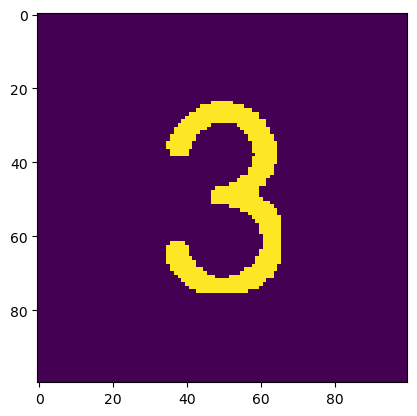

In [12]:
model1 = tf.keras.models.load_model('Printed Digits/PrintedDigitRecognizer.h5')
model2 = tf.keras.models.load_model('Models/model2.h5')


ordered_numbers = [3, 6, 5, 8, 4, 5, 2, 8, 7, 3, 1, 3, 1, 8, 9, 8, 6, 3, 5, 5, 9, 6, 1, 3, 2, 5, 7, 4, 5, 2, 6, 3]
counter = 0

model1_correct = 0
model2_correct = 0

for i in range(1, 82):
    image = get_square(i)
    h, w = image[:,:,0].shape
    if image[h*2//5:h*3//5, w*2//5:w*3//5].mean() > 10:
        print(f"Box {i}:")

        actual = ordered_numbers[counter]

        # model 1
        image1 = image[:,:,0]
        image1 = cv2.resize(image1, (100, 100))
        image1 = get_centered_digit(image1)
        image1 = np.array([image1])

        prediction1 = model1.predict(image1, verbose=0)
        guess1 = np.argmax(prediction1)

        if guess1 == actual:
            model1_correct += 1
            print("MODEL 1: Correct")
        else:
            print("MODEL 1: INCORRECT")


        # model 2
        image2 = image
        image2 = cv2.resize(image2, (28, 28))[:,:,0]
        image2 = image2.reshape((1, 28, 28, 1))

        prediction2 = model2.predict(image2, verbose=0)
        guess2 = np.argmax(prediction2)

        if guess2 == actual:
            model2_correct += 1
            print("MODEL 2: Correct\n")
        else:
            print("MODEL 2: INCORRECT\n")
        
        counter += 1

print(f"MODEL 1: {model1_correct}/{len(ordered_numbers)} ({round(model1_correct/len(ordered_numbers) * 100, 2)}%)")
print(f"MODEL 2: {model2_correct}/{len(ordered_numbers)} ({round(model2_correct/len(ordered_numbers) * 100, 2)}%)")
